<a href="https://colab.research.google.com/github/sourcecode369/deep-nlp/blob/master/machine%20translation/Sequence_to_Sequence_Models_for_Neural_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, print_function, unicode_literals, division
from builtins import input, range

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import urllib

TensorFlow 2.x selected.


In [3]:
try:
  print("Uploading...")
  from google.colab import files
  files.upload()
  print("File uploaded successfully.")
except Exception as ex:
  print(ex)

Uploading...


Saving spa-eng.zip to spa-eng.zip
File uploaded successfully.


In [4]:
import zipfile
with zipfile.ZipFile("spa-eng.zip",mode='r') as zf:
  zf.printdir() 
  print('Extracting all the files now...') 
  zf.extractall()
  print('Done!')
!ls -GFlash --color

File Name                                             Modified             Size
_about.txt                                     2020-01-11 23:49:12         1441
spa.txt                                        2020-01-11 23:49:12     18432706
Extracting all the files now...
Done!
total 23M
4.0K drwxr-xr-x 1 root 4.0K Jan 27 11:34 ./
4.0K drwxr-xr-x 1 root 4.0K Jan 27 11:17 ../
4.0K -rw-r--r-- 1 root 1.5K Jan 27 11:34 _about.txt
4.0K drwxr-xr-x 1 root 4.0K Jan 13 16:38 .config/
4.0K drwxr-xr-x 1 root 4.0K Jan 13 16:38 sample_data/
4.6M -rw-r--r-- 1 root 4.6M Jan 27 11:34 spa-eng.zip
 18M -rw-r--r-- 1 root  18M Jan 27 11:34 spa.txt


In [5]:
with open('spa.txt',mode='rb') as t:
  print(t.read(200))

b'Go.\tVe.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)\nGo.\tVete.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)\nGo.\tVaya.\tCC-BY 2.0 '


In [0]:
%tensorflow_version 2.x
import os, sys
import gc
gc.enable()

import numpy as np 
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")


In [0]:
BATCH_SIZE = 64
# BATCH_SIZE = 128
# BATCH_SIZE = 256
# BATCH_SIZE = 512

EPOCHS = 100

# LATENT_DIM = 512
LATENT_DIM = 1024
# LATENT_DIM = 2056

NUM_SAMPLES = 15000
MAX_SEQUENCE_LEGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 50

In [0]:
input_texts = []
target_texts = []
target_texts_inputs = []

In [9]:
#load in the data
t = 0
for line in open('spa.txt'):
  t+= 1
  if t>NUM_SAMPLES:
    print('Max Samples Exceeded. Breaking out of loop.')
    break
  if '\t' not in line:
    continue
  input_text, translation = line.split('\t')[:-1]
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation 

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples: ",len(input_texts))

Max Samples Exceeded. Breaking out of loop.
num samples:  15000


In [0]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [11]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.'% len(word2idx_inputs))

Found 3135 unique input tokens.


In [0]:
max_len_input = max(len(x) for x in input_sequences)

In [0]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [14]:
word2idx_outputs = tokenizer_outputs.word_index 
print('Found %s unique output tokens.'%len(word2idx_outputs))

Found 6530 unique output tokens.


In [0]:
num_words_output = len(word2idx_outputs) + 1
max_len_target = max(len(s) for s in target_sequences)

In [16]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print('encoder_data.shape',encoder_inputs)
print('encoder_data.shape[0]',encoder_inputs[0])

encoder_data.shape [[  0   0   0   0   0  20]
 [  0   0   0   0   0  20]
 [  0   0   0   0   0  20]
 ...
 [  0   0 135   9  10 634]
 [  0   0 135   9  10 541]
 [  0   0 135   9  10 541]]
encoder_data.shape[0] [ 0  0  0  0  0 20]


In [17]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target)
print('decoder_data.shape',decoder_inputs.shape)
print('decoder_data',decoder_inputs[0])

decoder_data.shape (15000, 10)
decoder_data [ 0  0  0  0  0  0  0  0  1 86]


In [0]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

In [19]:
import urllib
print('Downloading pretrained embedding vectors..')
urllib.request.urlretrieve("https://github.com/kmr0877/IMDB-Sentiment-Classification-CBOW-Model/raw/master/glove.6B.50d.txt.gz",filename="glove.6B.50d.txt.gz")

print('Extracting pretrained embedding vectors...')
import gzip
import shutil
with gzip.open('glove.6B.50d.txt.gz', 'rb') as f_in:
    with open('glove.6B.50d.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print('Loading pretrained embedding...')
word2vec = {}
with open('glove.6B.50d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print(f"Found {len(word2vec)} word vectors")

print('Filling pretrained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector      
print('Done.!')

embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_len_input)

Extracting pretrained embedding vectors...
Loading pretrained embedding...
Found 400000 word vectors
Filling pretrained embeddings...
Done.!


In [0]:
decoder_targets_one_hot = np.zeros((len(input_texts), max_len_target, num_words_output), dtype='float32')

In [0]:
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [0]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True,   dropout=0.5)
encoder_outputs, h, c = encoder(x)

encoder_states = [h, c]

decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True,dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs_x,
    initial_state = encoder_states
)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

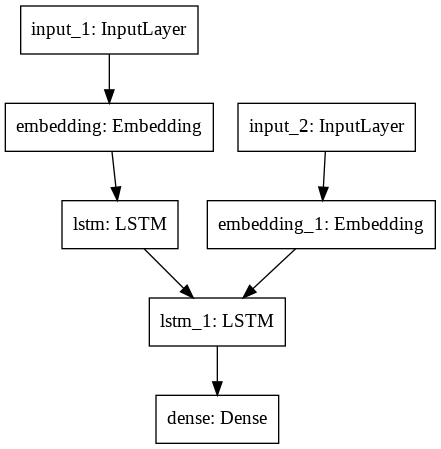

In [23]:
tf.keras.utils.plot_model(model)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 6, 50)        156800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 1024)     6687744     input_2[0][0]                    
______________________________________________________________________________________________

In [25]:
r = model.fit([encoder_inputs, decoder_inputs], decoder_targets_one_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='min',restore_best_weights=True)])

Train on 12000 samples, validate on 3000 samples
Epoch 1/100
12000/12000 [==============================] - 32s 3ms/sample - loss: 2.4397 - accuracy: 0.6471 - val_loss: 2.5507 - val_accuracy: 0.6186
Epoch 2/100
12000/12000 [==============================] - 21s 2ms/sample - loss: 1.9933 - accuracy: 0.6803 - val_loss: 2.3658 - val_accuracy: 0.6457
Epoch 3/100
12000/12000 [==============================] - 20s 2ms/sample - loss: 1.7614 - accuracy: 0.7034 - val_loss: 2.2300 - val_accuracy: 0.6674
Epoch 4/100
12000/12000 [==============================] - 21s 2ms/sample - loss: 1.5523 - accuracy: 0.7219 - val_loss: 2.1035 - val_accuracy: 0.6819
Epoch 5/100
12000/12000 [==============================] - 20s 2ms/sample - loss: 1.3717 - accuracy: 0.7365 - val_loss: 2.0384 - val_accuracy: 0.6941
Epoch 6/100
12000/12000 [==============================] - 21s 2ms/sample - loss: 1.2126 - accuracy: 0.7480 - val_loss: 1.9689 - val_accuracy: 0.6994
Epoch 7/100
12000/12000 [==========================

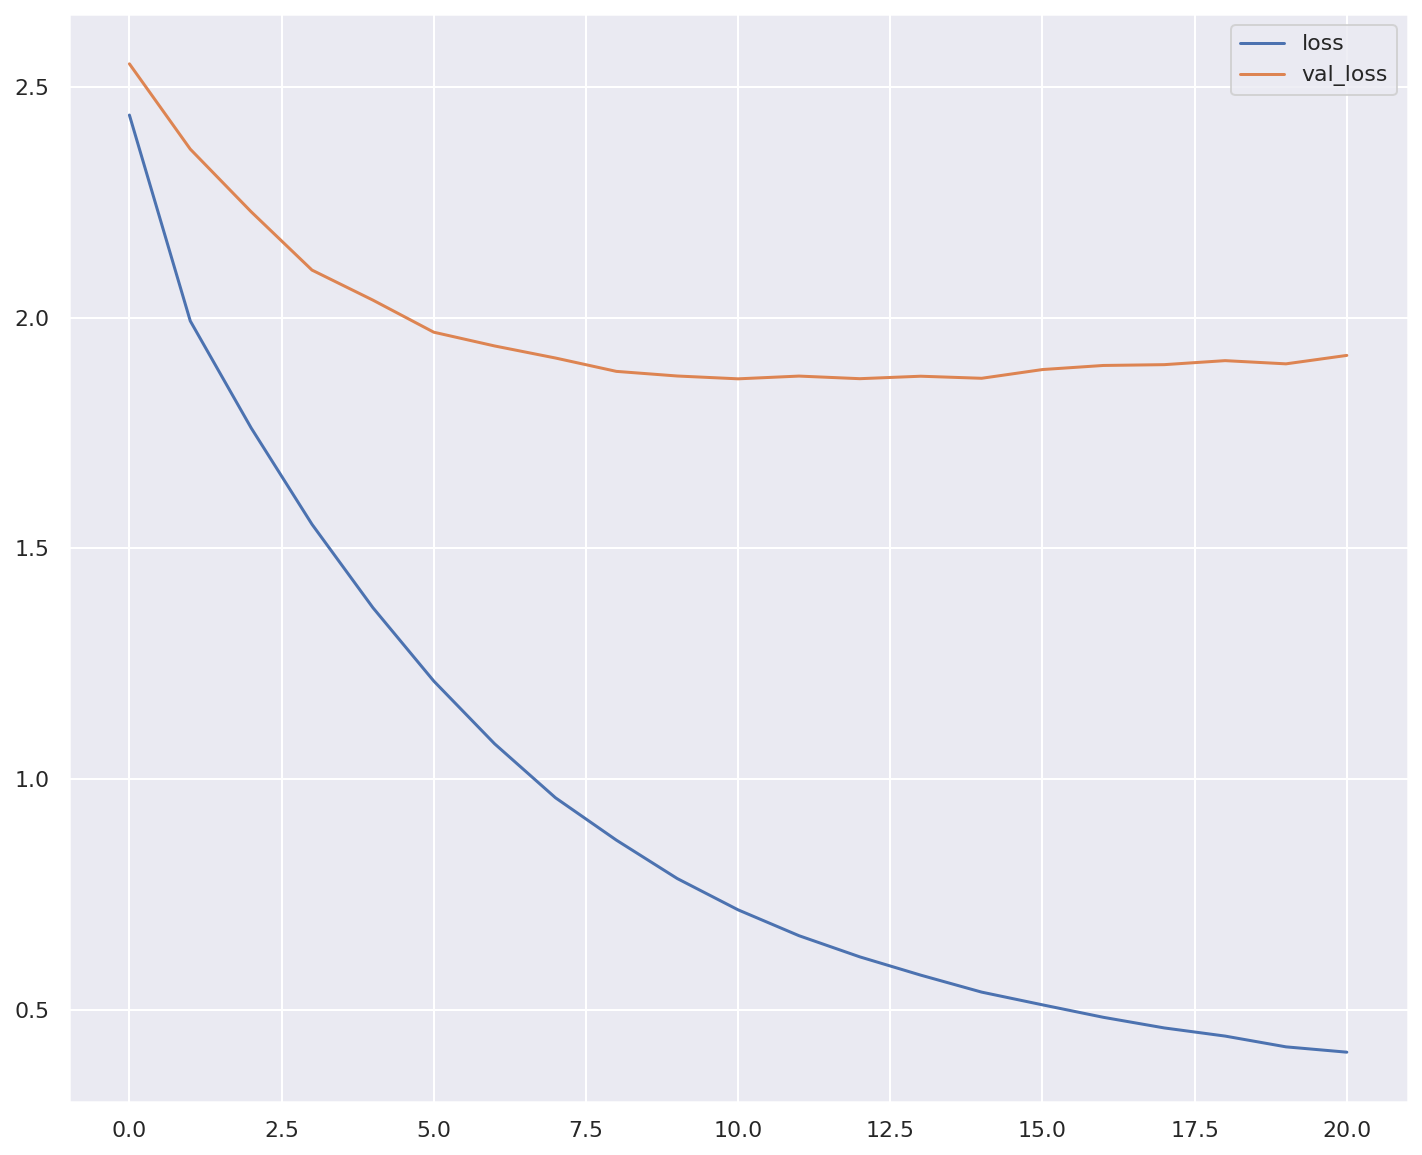

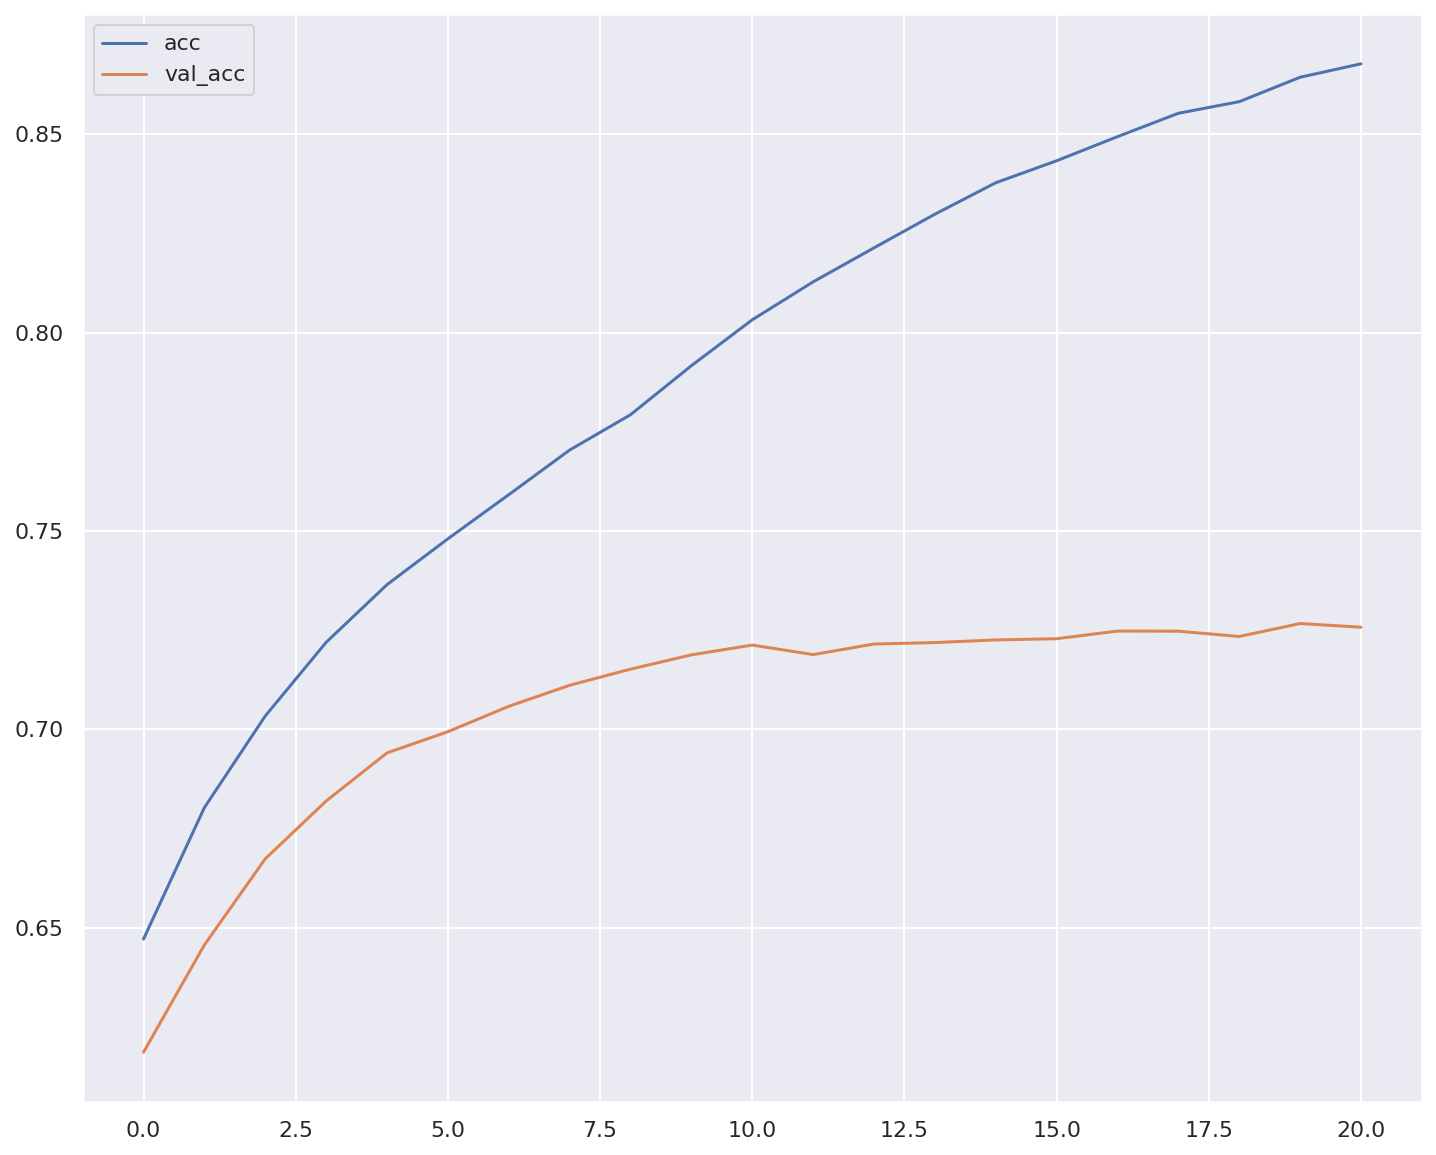

In [26]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
sns.set(rc={"figure.figsize":(12,10)})

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [0]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

decoder_states = [h, c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [0]:
idx2word_eng = {v:k for k,v in word2idx_inputs.items()}
idx2word_trans = {v:k for k,v in word2idx_outputs.items()}

In [0]:
def decode_sequence(input_seq):
  states_value = encoder_model.predict(input_seq)

  target_seq = np.zeros((1,1))
  target_seq[0, 0] = word2idx_outputs['sos']

  eos = word2idx_outputs['eos']
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
        [target_seq] + states_value
    )
    idx = np.argmax(output_tokens[0,0,:])

    if eos == idx:
      break
    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)
    target_seq[0, 0] = idx
    states_value = [h, c]
  return ' '.join(output_sentence)

In [35]:
while True:
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input: ',input_texts[i])
  print('Translation: ',translation)
  print('Spanish to English: ',input())
  ans = input('Continue? [Y/n]')
  if ans and ans.lower().startswith('n'):
    break

-
Input:  We've got time.
Translation:  la hemos a la
we have it to the
Spanish to English:  we have it to the
Continue? [Y/n]Y
-
Input:  Open the safe.
Translation:  el las la ventanas
the windows
Spanish to English:  the windows
Continue? [Y/n]Y
-
Input:  You look tired.
Translation:  se pareces de de
you look like from
Spanish to English:  you look like from
Continue? [Y/n]y
-
Input:  I'm not in a rush.
Translation:  no no en en la
no no in on the
Spanish to English:  no no in on the
Continue? [Y/n]n


In [0]:
# we're going to use attention mechanism for the same task and going to check the performance on the same dataset